In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt

# Helpers
from testing import *
# Baseline model 1
from transformers import RobertaTokenizer, RobertaForMaskedLM, pipeline
# Sentence similarity model
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
from transformers import AutoTokenizer, AutoModel

# Check if GPU acceleration is available
if torch.cuda.is_available():
    device = "cuda"
    device_num = torch.cuda.current_device()
else:
    device = "cpu"
    device_num = -1

print(f"Using {device} device")

Using cuda device


## Fine-tuning by "Cosine Similarity"

In [2]:
# Run this if you removed pickle files
# saving_pickles()

train_df, valid_df, test_df = loading_pickles()

In [3]:
# Constants ----------------------------------------------------------------------------------------------------------------

# For training (not validation)
batch_size = 10

# Using only a portion of the train dataset for performance
# Set it to 1 to use all train dataset; increasing this may give better result.
size_proportion_train = 0.01

# Hyperparameters ----------------------------------------------------------------------------------------------------------

total_epoch_number = 3
# Initial learning rate for the optimizer
learning_rate = 1.00E-03
weight_decay_coefficient = 0.01

In [4]:
# Do not change these values unless necessary
mask_prob = 0.5
window_size = 100
rng_seed = 42
# Train and Valid
shuffle = True
size_proportion_valid = size_proportion_train
tokenizer_cs = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model_cs = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [5]:
def masking_df(code_df):
    masked_code_df = mask_variable_df(code_df, mask_prob=mask_prob, rng_seed=rng_seed)
    merged_code_df = pd.concat([code_df, masked_code_df], axis="columns")
    return merged_code_df

def window_df(code_df):
    merged_code_df = masking_df(code_df)
    return split_into_windows(merged_code_df, window_size=window_size, mask_token="<mask>")

train_df_size = int(len(train_df) * size_proportion_train)
valid_df_size = int(len(valid_df) * size_proportion_valid)

if shuffle:
    train_df = train_df.sample(frac=1, random_state=rng_seed).reset_index(drop=True)
    valid_df = valid_df.sample(frac=1, random_state=rng_seed).reset_index(drop=True)

window_train_df = window_df(train_df[:train_df_size])

merged_valid_df = masking_df(valid_df[:valid_df_size])
merged_test_df = masking_df(test_df)

Masking:   0%|          | 0/4121 [00:00<?, ?it/s]

Window split:   0%|          | 0/4121 [00:00<?, ?it/s]

Masking:   0%|          | 0/231 [00:00<?, ?it/s]

Masking:   0%|          | 0/22176 [00:00<?, ?it/s]

three ways to fine tune the model:
1. Fine-tune the last head of the model <- Current approach
2. Fine-tune the whole model
3. Add extra layers to the model and fine tune the additional layer

We use the first baseline model, as it showed the better performance in the baseline testing.
See the baseline_testing notebook for more details.

There are three main hyperparameters: total_epoch_number, learning_rate, and weight_decay_coefficient
Try different combinations to fine the best performing model. I commented thoroughly so there should be no problem in understanding the codes.
If you want to change the optimizer, then you need to directly edit the optimizer definition in the training loop cell.
There are other changeable constants, and varying them may also give a better performance. For example, if you increase size_limit_proportion_train,
the more training set will be used for the fine-tuning. But the fine-tuning time will be increased too.

After a model is fine-tuned, its performance will then be evaluated based on the average cosine similarity with the validation set.
You can check if the fine-tuned model performs better or worse compared to the baseline model. If your model performs well, then
consider saving the model so that we can use it later. For performance, it is set to only use the half of the validation set.

If any error occurs, or if you have a suggestion, let me know.


### Model investigation

You need to uncomment some cells to see the results.

In [6]:
# All Huggingface models are standard torch.nn.Module, so they can easily be used in any training loop.

# Model architecture information:
# https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/roberta#transformers.RobertaForMaskedLM
model_b1 = RobertaForMaskedLM.from_pretrained('microsoft/codebert-base-mlm')
tokenizer_b1 = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [7]:
# Model structure (Uncomment to see)
# print(model_b1)

# Embedding size = (50265, 768)
# Dropout probability = 0.1

In [8]:
# Model parameters (Uncomment to see)

# for name, param in model_b1.named_parameters():
#     print(name)

In [9]:
# Freeze parameters except the last head

for name, param in model_b1.named_parameters():
    if "lm_head" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

    print(name, param.requires_grad)

roberta.embeddings.word_embeddings.weight False
roberta.embeddings.position_embeddings.weight False
roberta.embeddings.token_type_embeddings.weight False
roberta.embeddings.LayerNorm.weight False
roberta.embeddings.LayerNorm.bias False
roberta.encoder.layer.0.attention.self.query.weight False
roberta.encoder.layer.0.attention.self.query.bias False
roberta.encoder.layer.0.attention.self.key.weight False
roberta.encoder.layer.0.attention.self.key.bias False
roberta.encoder.layer.0.attention.self.value.weight False
roberta.encoder.layer.0.attention.self.value.bias False
roberta.encoder.layer.0.attention.output.dense.weight False
roberta.encoder.layer.0.attention.output.dense.bias False
roberta.encoder.layer.0.attention.output.LayerNorm.weight False
roberta.encoder.layer.0.attention.output.LayerNorm.bias False
roberta.encoder.layer.0.intermediate.dense.weight False
roberta.encoder.layer.0.intermediate.dense.bias False
roberta.encoder.layer.0.output.dense.weight False
roberta.encoder.layer.

### Preparing the dataset

In [10]:
class CodeNetDataset(Dataset):
    def __init__(self, window_df, tokenizer):
        self.window_df = window_df
        self.tokenizer = tokenizer
        self.mask_token_id = tokenizer.mask_token_id

        # Not sure how to apply tqdm (progress bar) for this; I plan to update soon
        self.tokenized = tokenizer(list(window_df["window"]), padding=True)
        self.input_ids = self.tokenized["input_ids"]
        self.attention_mask = self.tokenized["attention_mask"]
        self.label = self.window_df["label"]

    def __len__(self):
        return len(self.window_df)

    def __getitem__(self, index):
        mask_token_index = self.input_ids[index].index(self.mask_token_id)
        # String cannot be stored in a tensor. They need to be converted to numeric values first.
        label_token_id = self.tokenizer.convert_tokens_to_ids(self.label[index])

        return torch.tensor(self.input_ids[index]), torch.tensor(self.attention_mask[index]), torch.tensor(mask_token_index), torch.tensor(label_token_id)

train_dataset = CodeNetDataset(window_train_df, tokenizer_b1)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

### Fine-tuning (Cosine Similarity)

We only use the top_1 prediction as it showed the best performance in the baseline testing.

In [11]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Cosine similarity loss is calculated for each batch, before backpropagation.
def cosine_similarity_loss(prediction_logits, mask_token_indices, label_token_ids):

    cosine_similarity_list = list()
    for row, mask_token_index, label_token_id in zip(range(prediction_logits.shape[0]), mask_token_indices, label_token_ids):
        prediction_word_id = torch.argmax(prediction_logits[row, mask_token_index])
        # Words will be stripped to remove unnecessary whitespaces.
        prediction_word = tokenizer_b1.decode(prediction_word_id).strip()
        label_word = tokenizer_b1.decode(label_token_id).strip()

        # Computing cosine similarity
        encoded_words = tokenizer_cs([label_word, prediction_word], padding=True, truncation=True, return_tensors='pt')
        with torch.no_grad():
            model_cs_output = model_cs(**encoded_words)
        word_embeddings = mean_pooling(model_cs_output, encoded_words["attention_mask"])
        word_embeddings = F.normalize(word_embeddings, p=2, dim=1)
        dot_product = torch.dot(word_embeddings[0, :], word_embeddings[1, :])
        # dot_product is a zero-dimensional tensor. We need to add a dummy dimension at 1 for concatenation.
        cosine_similarity_list.append(torch.unsqueeze(dot_product, dim=0))

    # The mean cosine similarity for a batch
    # -1 is multiplied because we are minimizing the loss
    return torch.mean(torch.concat(cosine_similarity_list)).requires_grad_() * -1

In [12]:
# Running this cell multiple times in a single notebook can fully saturate the GPU memory, which leads the OutOfMemoryError.
# If it happens, re-start the notebook kernel to remove all model instances from the GPU memory.
# It seems like the memory error sometimes happens when the dataset size is too big, regardless of the batch size.
# I am not sure why it is the case; Let me know if you encounter this issue.

# Setting the model to the train mode
model_b1.train()
model_b1.to(device)

print(f"Total train set size: {len(train_dataset)}, batch_size: {batch_size}, batch_number: {math.ceil(len(train_dataset) / batch_size)}")
train_similarity = list()
valid_similarity = list()

# Using the AdamW optimizer: https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html
# Feel free to try others
optimizer = torch.optim.AdamW(model_b1.parameters(), lr=learning_rate, weight_decay=weight_decay_coefficient)

for epoch_num in range(1, total_epoch_number+1):
    loss_list = list()
    model_b1.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch_num}", total=math.ceil(len(train_dataset) / batch_size)):
        # Sending to GPU
        batch_input_ids = batch[0].to(device)
        batch_attention_mask = batch[1].to(device)
        batch_mask_token_index = batch[2].to(device)
        batch_label_token_id = batch[3].to(device)

        # Forward pass
        prediction_logits = model_b1(input_ids=batch_input_ids, attention_mask=batch_attention_mask).logits
        # Computing prediction error
        loss = cosine_similarity_loss(prediction_logits, batch_mask_token_index, batch_label_token_id)
        # Removing gradients from the past iteration
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

        # Removing to free up memory
        del batch_input_ids
        del batch_attention_mask
        del batch_mask_token_index
        del batch_label_token_id
        torch.cuda.empty_cache()

    # Computing the validation loss for each epoch
    model_b1.eval()
    eval_pipeline = pipeline('fill-mask', model=model_b1, tokenizer=tokenizer_b1, device=device_num)
    eval_pipeline_result = model_test(merged_code_df=merged_valid_df, unmasker=eval_pipeline, top_k=1, window_size=window_size, batch_size=batch_size)
    eval_similarity = np.mean(eval_pipeline_result['similarity'])

    print(f"Epoch {epoch_num}, Train cosine similarity {-1 * np.mean(loss_list)}, Valid cosine similarity {eval_similarity}")
    train_similarity.append(-1 * np.mean(loss_list))
    valid_similarity.append(eval_similarity)

Total train set size: 11684, batch_size: 50, batch_number: 234


Epoch 1:   0%|          | 0/234 [00:00<?, ?it/s]

Window split:   0%|          | 0/231 [00:00<?, ?it/s]

Prediction:   0%|          | 0/633 [00:00<?, ?it/s]

Similarity:   0%|          | 0/633 [00:00<?, ?it/s]

Epoch 1, Train cosine similarity 0.43256954403005093, Valid cosine similarity 0.4904963970184326


Epoch 2:   0%|          | 0/234 [00:00<?, ?it/s]

Window split:   0%|          | 0/231 [00:00<?, ?it/s]

Prediction:   0%|          | 0/633 [00:00<?, ?it/s]

Similarity:   0%|          | 0/633 [00:00<?, ?it/s]

Epoch 2, Train cosine similarity 0.4336445043102289, Valid cosine similarity 0.4904963970184326


Epoch 3:   0%|          | 0/234 [00:00<?, ?it/s]

Window split:   0%|          | 0/231 [00:00<?, ?it/s]

Prediction:   0%|          | 0/633 [00:00<?, ?it/s]

Similarity:   0%|          | 0/633 [00:00<?, ?it/s]

Epoch 3, Train cosine similarity 0.43513464978617483, Valid cosine similarity 0.4904963970184326


### Validation (Cosine similarity)

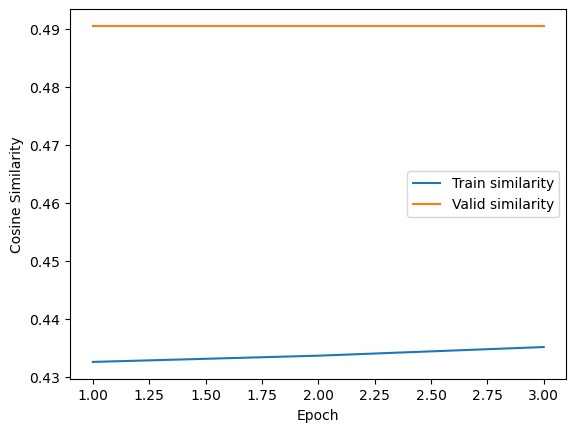

In [13]:
# Uncomment to draw loss plot
plt.plot(range(1, len(train_similarity) + 1), train_similarity, label="Train similarity")
plt.plot(range(1, len(valid_similarity) + 1), valid_similarity, label="Valid similarity")
plt.xlabel("Epoch")
plt.ylabel("Cosine Similarity")
plt.legend()

In [14]:
b1_finetuned = pipeline('fill-mask', model=model_b1, tokenizer=tokenizer_b1, device=device_num)
b1_finetuned_result = model_test(merged_code_df=merged_valid_df, unmasker=b1_finetuned, top_k=1, window_size=window_size, batch_size=batch_size)

Window split:   0%|          | 0/231 [00:00<?, ?it/s]

Prediction:   0%|          | 0/633 [00:00<?, ?it/s]

Similarity:   0%|          | 0/633 [00:00<?, ?it/s]

In [15]:
torch.cuda.empty_cache()

In [16]:
average_similarity = np.mean(b1_finetuned_result['similarity'])
# Baseline performance (I plan to send you the result by this evening)
baseline_similarity = 0.4816761314868927
print(f"Average cosine similarity: {average_similarity}")
if average_similarity < baseline_similarity:
    print(f"The fine-tuned model performance is worse than the baseline, by {baseline_similarity-average_similarity}")
else:
    print(f"The fine-tuned model performance is better than the baseline, by {average_similarity-baseline_similarity}")

Average cosine similarity: 0.4904963970184326
The fine-tuned model performance is better than the baseline, by 0.008820265531539917


### Saving the model

Check the following for loading the model: https://pytorch.org/docs/stable/generated/torch.load.html#torch.load

In [24]:
# Saving the hyperparameters and the fine-tuned model
# The model size is around 500 MB. You may want to save the dictionary only
training_constants = [batch_size, shuffle, size_proportion_train, total_epoch_number, learning_rate, weight_decay_coefficient, mask_prob, window_size, rng_seed, size_proportion_valid]
result_dict = {"training_constants": training_constants,
               "train_similarity": train_similarity,
               "valid_similarity": valid_similarity,
               "loss_metric": "cosine_similarity",
               "valid_final_similarity": average_similarity}

In [25]:
# Generating non-existing filenames
file_index = 0
while os.path.exists(f"./saved_models/model_{file_index}"):
    file_index += 1

model_filepath = f"./saved_models/model_{file_index}"
hparameter_filepath = f"./saved_models/hparameter_{file_index}"

In [ ]:
# Saving the hyperparameters and results
with open(hparameter_filepath, "wb") as fw:
    pickle.dump(result_dict, fw)

In [26]:
# Saving the model
torch.save(model_b1, model_filepath)